# Outliers removal in Time Series

### Notebook by **David Andrés** 🤖📈🐍 

#### for [💊Machine Learning Pills💊](https://mlpills.dev/)

**Follow me on Twitter**: [@daansan_ml](https://twitter.com/daansan_ml)




---------------

Let's install the libraries we will need and import them

In [2]:
import numpy as np
import pandas as pd 

import datetime

import matplotlib.pyplot as plt

## Import dataset

First we need to import the dataset. 

In this notebook we will work with data about the monthly beer production in Australia.

You can download the dataset by running the following cell:

In [3]:
!wget -P ./dataset --no-check-certificate --content-disposition https://raw.githubusercontent.com/MLPills/missing-values-and-detrending/main/dataset/monthly-beer-production-in-austr.csv

--2023-04-17 14:55:56--  https://raw.githubusercontent.com/MLPills/missing-values-and-detrending/main/dataset/monthly-beer-production-in-austr.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6426 (6.3K) [text/plain]
Saving to: ‘./dataset/monthly-beer-production-in-austr.csv’

monthly-beer-produc 100%[===================>]   6.28K  --.-KB/s    in 0s      

2023-04-17 14:55:56 (56.1 MB/s) - ‘./dataset/monthly-beer-production-in-austr.csv’ saved [6426/6426]



In [4]:
df = pd.read_csv("dataset/monthly-beer-production-in-austr.csv")

### Exploratory Data Analysis

Let's check now how the dataset looks like.

In [5]:
df.head()

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


In time series we need the index of the dataframe to be the date.

First, let's double-check that the date is in the right format (datetime).

In [6]:
df.dtypes

Month                       object
Monthly beer production    float64
dtype: object

The `Month` column is not a datetime type. So let's convert it!

In [7]:
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m')

We can now verify that the changes are correct.

In [8]:
df.dtypes

Month                      datetime64[ns]
Monthly beer production           float64
dtype: object

Let's set the date (`Month`) as the index.

In [9]:
df = df.set_index('Month')

And finally verify that it worked.

In [10]:
df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


We have it now as we wanted, the index of the dataframe is the date.

Let's also convert the dataframe to series by selecting the only column present. We can do this here because we are in an univariate case.

In [11]:
df_beer = df['Monthly beer production']

It is important that we also visualize the data.

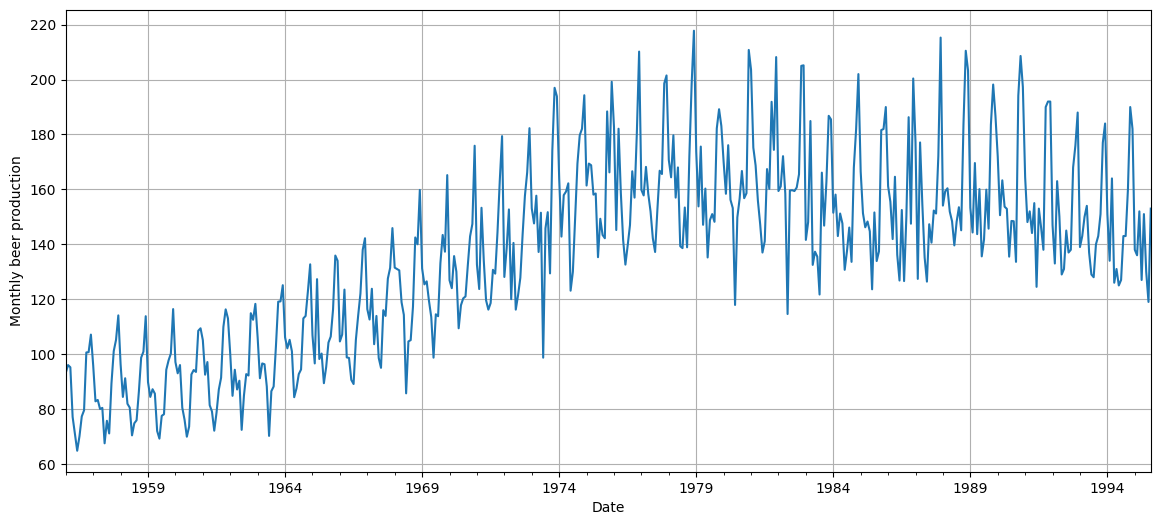

In [12]:
# Import required libraries
import matplotlib.pyplot as plt

# Plot data
df_beer.plot(figsize=(14,6))
plt.xlabel('Date')
plt.ylabel('Monthly beer production')
plt.grid()
plt.show()

Some observations:
* It is non-stationary
* There seems to be a seasonal component
* There is a trend and an increasing variance
* It looks like there are some outliers

### Missing values

We need to check if there are any missing values in the dataframe.

In [13]:
df_beer.isna().sum()

0

Fortunately for us there are not.

### Remove the trend

The first step to achieving that is to remove the trend. There are many ways of achieving this, we will use *differencing*.

In [14]:
df_beer = df_beer.diff()

We need to drop the first *NaN* value coming from taking the difference.

In [15]:
df_beer = df_beer.dropna()

We can now see how it looks.

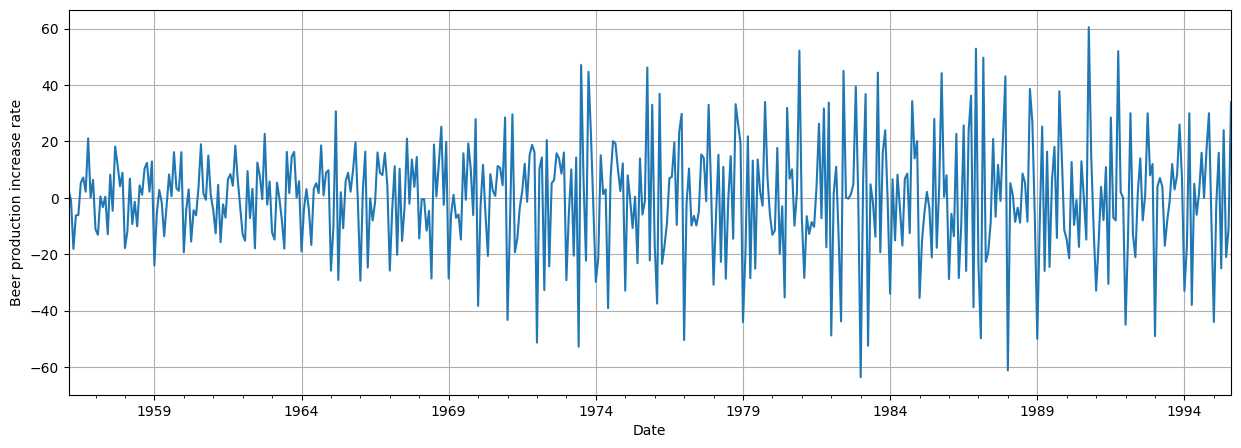

In [16]:
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Beer production increase rate')
plt.grid()
plt.show()

You can see that now it is centered around zero.

However, we still have increasing volatility, which we need to address to achieve stationarity.

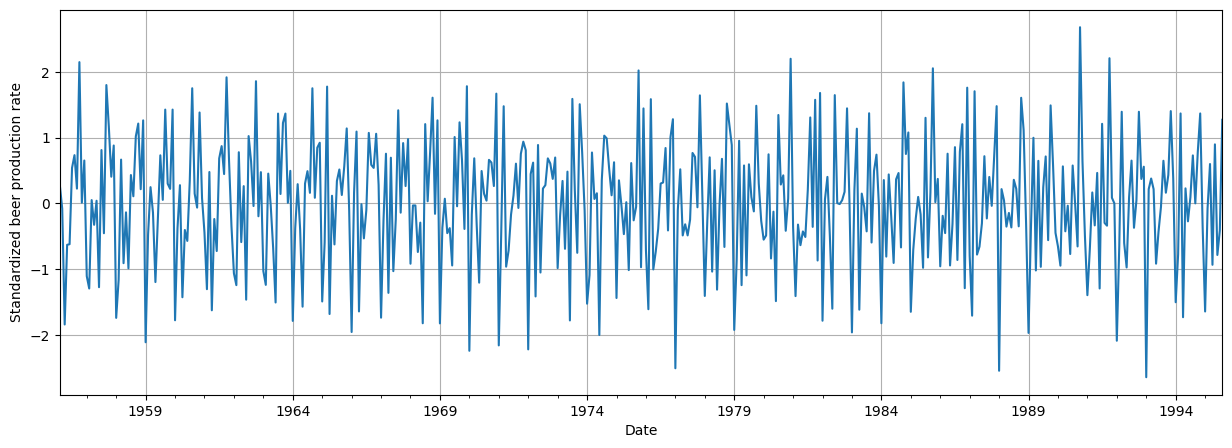

In [17]:
# Calculate each year's variance (equivalent to standard deviation)
annual_variance = df_beer.groupby(df_beer.index.year).std()
mapped_annual_variance = df_beer.index.map(
    lambda x: annual_variance.loc[x.year])

# Standardize each year's variance
df_beer = df_beer / mapped_annual_variance

# Plot outcome
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Standardized beer production rate')
plt.grid()
plt.show()

### Remove seasonality

Before starting, we could use Python’s statsmodels library to see the seasonal decomposition of the data before we removed the trend. This is not a required step, but it could be useful to visualize the components of the time series data. Before using it, we need to select the seasonality period. We assume there is anual seasonality, so we will set it to 12 (12 months in a year).

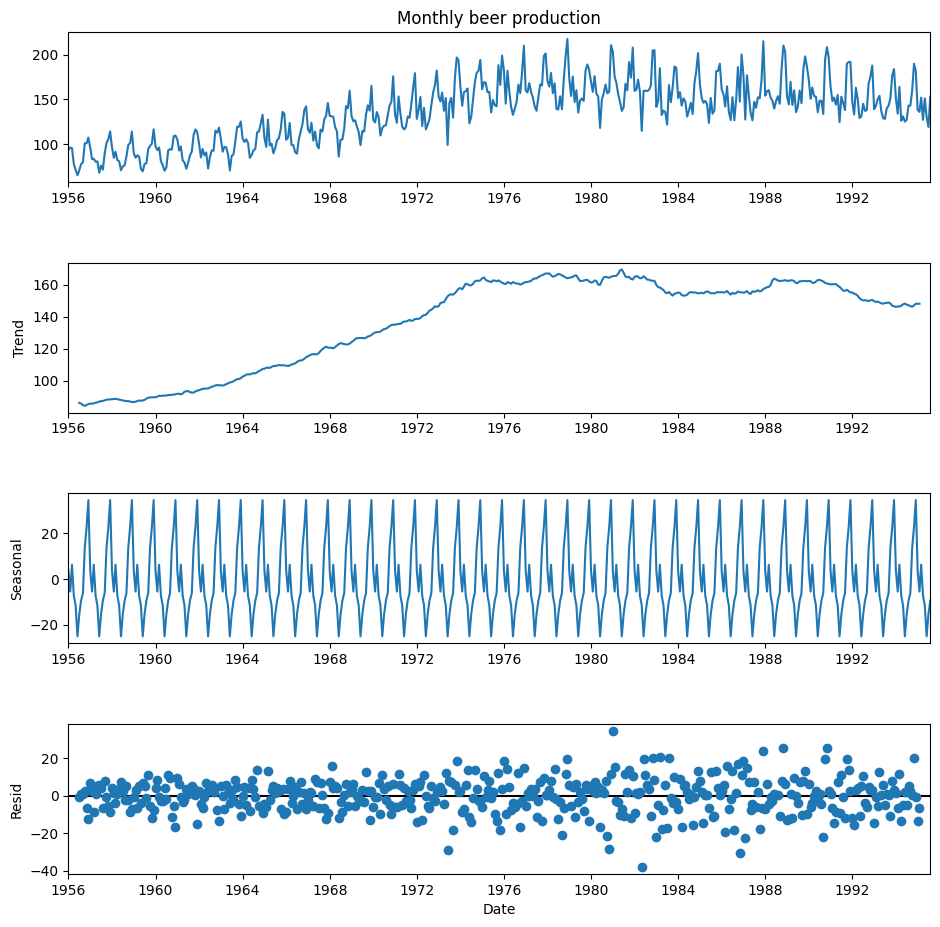

In [18]:
# Import library
import statsmodels.api as sm

# Decompose data by selecting the appropiate frequency
decomp = sm.tsa.seasonal_decompose(
  df['Monthly beer production'], period=12)
decomp_plot = decomp.plot()

# Plot outcome
plt.xlabel('Date')
decomp_plot .set_figheight(10)
decomp_plot .set_figwidth(10)
plt.show()

As expected, we can see one production peak every year and a smooth trend without ups and downs, only the actual trend over the years. We can also see the residuals, which refer to all noise or anomalies during this period of time after extracting the seasonal component and the trend.

We will use a more intuitive approach for removing the seasonality from our data.

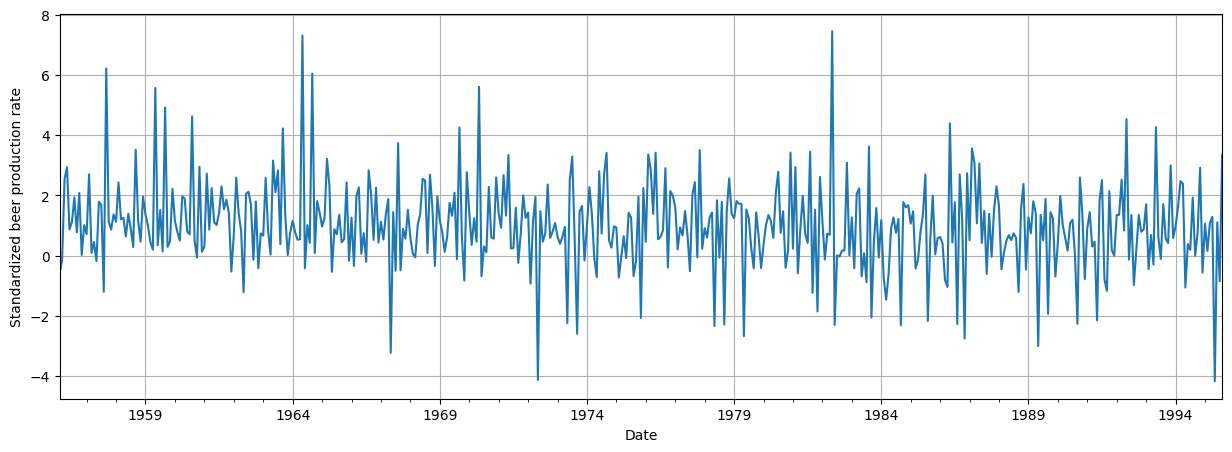

In [19]:
# Calculate each year's average
monthly_average = df_beer.groupby(df_beer.index.month).mean()
mapped_monthly_average = df_beer.index.map(
    lambda x: monthly_average.loc[x.month])

# Standardize each year's average
df_beer = df_beer / mapped_monthly_average

# Plot outcome
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Standardized beer production rate')
plt.grid()
plt.show()

We can see now that the outcome looks pretty random and therefore stationary. We could check if this is actually the case.

### Check for stationarity

Stationarity refers to a property of the data where statistical properties such as the mean, variance, and autocorrelation structure remain constant over time.

We can use the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test to check for stationarity in a time series:

In [20]:
# Import required libraries
from statsmodels.tsa.stattools import adfuller, kpss

# Perform ADF test
result = adfuller(df_beer)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(df_beer)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

ADF test:	p-value: 0.001
KPSS test:	p-value: 0.010


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


For the ADF test, we need to check if the p-value is lower than the significance level (often set as 0.05). In this case, it is, so the data is stationary according to this criteria.
For the KPSS test, we need to check if the p-value is greater than the significance level. In this case, it is lower than 0.05, therefore it is not stationary according to this test.

We still need to work on making our data stationary. We can simply apply another differencing and perform both tests again.

In [21]:
# Apply one more differencing to the data
df_beer = df_beer.diff()[1:]

# Perform ADF test
result = adfuller(df_beer)
print('ADF test:\tp-value: {:.3f}'.format(result[1]))

# Perform KPSS test
result = kpss(df_beer)
print('KPSS test:\tp-value: {:.3f}'.format(result[1]))

ADF test:	p-value: 0.000
KPSS test:	p-value: 0.100


/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


Now the ADF test p-value is still lower than 0.05 and the KPSS test p-value is greater than 0.05. Therefore we have stationary time series data.

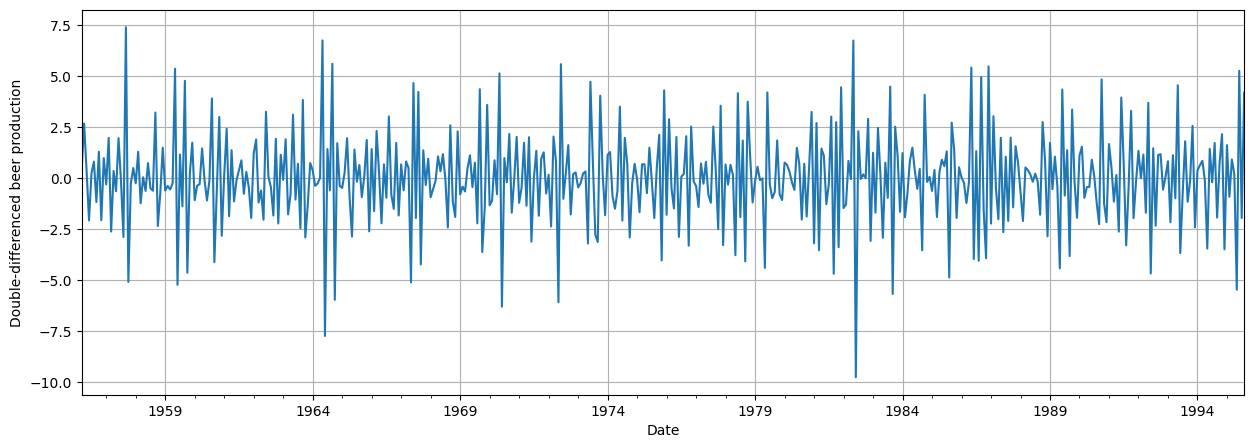

In [22]:
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Double-differenced beer production')
plt.grid()
plt.show()

### Normalize the data

The next step is to bring the data to a common scale, this is called normalization.

We will use the Standard Scaler, since it will be useful later for removing the outliers. There are two alternatives here: the intuitive approach and the one using the scikit-learn library.

The intuitive approach is very easy and straightforward to implement:

In [23]:
# Calculate mean and standard deviation
mean = df_beer.mean()
std = df_beer.std()

# Normalize data
df_beer = (df_beer - mean) / std

We can also do it with the scikit-learn function:

In [24]:
# Import library
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

# Convert data to numpy array and reshape
array_beer = df_beer.values.reshape(-1, 1)

# Fit the scaler to the data and transform it
data_scaled = scaler.fit_transform(array_beer)

# Convert back to pandas Series
df_beer = pd.Series(data_scaled.flatten(), 
                    index=df_beer.index, name='Month')

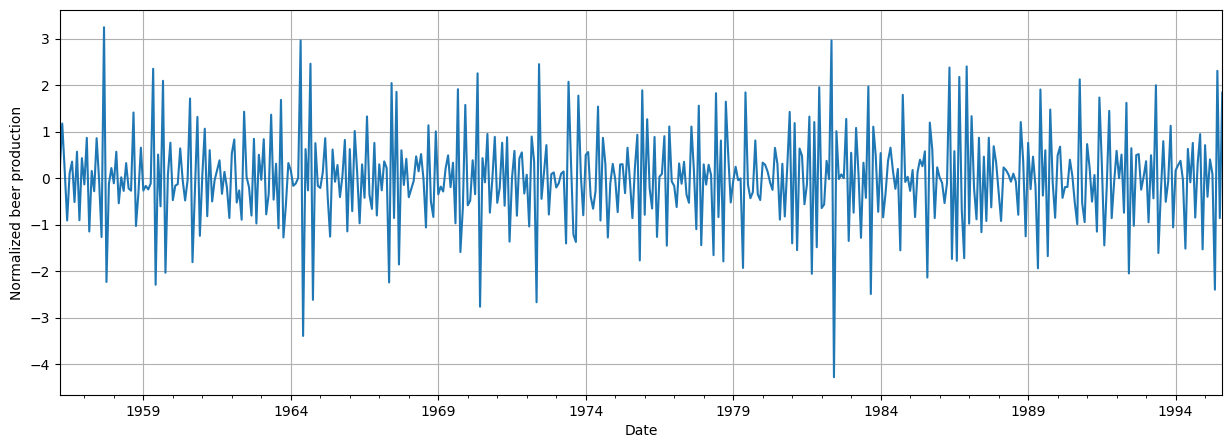

In [25]:
df_beer.plot(figsize=(15,5))
plt.xlabel('Date')
plt.ylabel('Normalized beer production')
plt.grid()
plt.show()

We can finally see how our data is stationary and normalized.

### Remove outliers

In [26]:
# Convert the Series back to DataFrame
df_beer = df_beer.to_frame()
df_beer.columns = ['Production']

A box-plot shows the distribution of the data and identifies any outliers as points that fall outside the "whiskers" of the plot. 

We have monthly data, so it would be better if we group them by month to find the outliers.

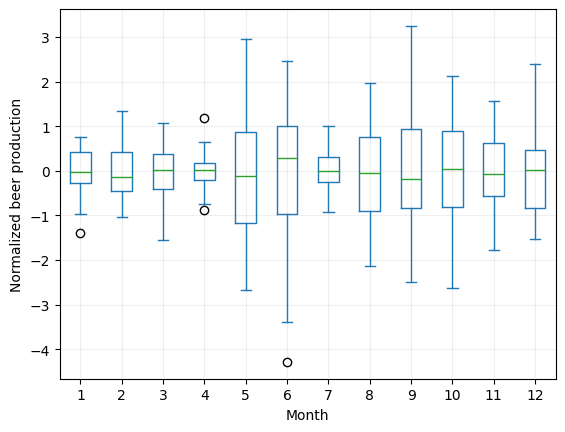

In [27]:
# Group by month
df_beer.set_index(df_beer.index.month, append=True).Production.unstack().plot.box()
plt.xlabel('Month')
plt.ylabel('Normalized beer production')
plt.grid(which='both', alpha=0.2)
plt.show()

We have identified four outliers in our dataset (black circles on the graph). To identify these outliers, we used the interquartile range (IQR) test.

The interquartile range test is a statistical method used to identify potential outliers in a dataset. It involves calculating the difference between the first quartile (Q1) and the third quartile (Q3) of the data distribution. The IQR is then multiplied by a constant factor, typically 1.5, to define the lower and upper limits of the expected range of data values. Data points that fall outside of this expected range are considered potential outliers.

In [28]:
# Remove outliers according to month

# Create a list to gather abnormal dates
abnormal_values_dates = []

for month in range(13):

    # Group values by month
    df_month = df_beer[df_beer.index.month == month]
    
    # Calculate Q1, Q3 and interquartile range
    q1 = df_month.Production.quantile(0.25)
    q3 = df_month.Production.quantile(0.75)
    iqr = q3 - q1
    
    # Find anomalies
    abnormal_dates = df_month[(df_month.Production < q1 - 1.5 * iqr) \
                         | (df_month.Production > q3 + 1.5 * iqr)].index
    
    # Add anomalies to a list
    if not abnormal_dates.empty:
      abnormal_values_dates = abnormal_values_dates + list(abnormal_dates)

The Z-score test is a commonly used statistical method for identifying outliers in time series data. 

When working with time series data, it’s common to calculate the Z-score using a rolling window approach. We can ensure that our analysis is more focused on recent trends and patterns in the data.

We can use the Z-score test with a 24-month rolling window for a more complete analysis. By doing so, we can identify any data points that fall outside of the expected range and consider them as potential outliers that require further investigation.

In [29]:
# Define the z-score function
def zscore(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z
    
# Calculate zscore with a rolling window and get abnormal values
window_size = 24 
df_zscore = zscore(df_beer, window_size)

# Apply a threshold for the z-score and add abnormal values to the list
threshold = 3
abnormal_values_dates = abnormal_values_dates + \
   list(df_zscore[abs(df_zscore.Production) > threshold].index)


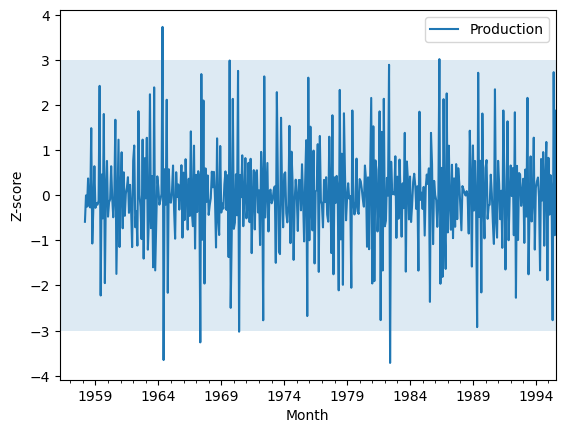

In [30]:
# Display the normal range of values according to our threshold
df_zscore.plot()
plt.fill_between(df_zscore.index.values, -3, 3, alpha=0.15)
plt.ylabel('Z-score')
plt.show()

Once outliers have been identified, they can be removed from the data set. We will set them to NaN so we can deal with them later.

In [31]:
# Set anomalies to NaN
df_beer.loc[abnormal_values_dates, 'Production'] = np.nan

One way is simply interpolating.

In [32]:
# Interpolate
df_beer = df_beer.interpolate()

Other way is calculating the average production per month and imputing these values.

In [33]:
# Calculate the average production per month
monthly_avg = df_beer.groupby(df_beer.index.month).mean()

# Impute these values
for month in monthly_avg.index:
    df_beer.loc[df_beer.index.month == month, 'Production'] = \
        df_beer.loc[df_beer.index.month == month, 'Production'].fillna(
            monthly_avg.loc[month, 'Production'])


It all depends on your particular case. Try different strategies and assess the best case for you.

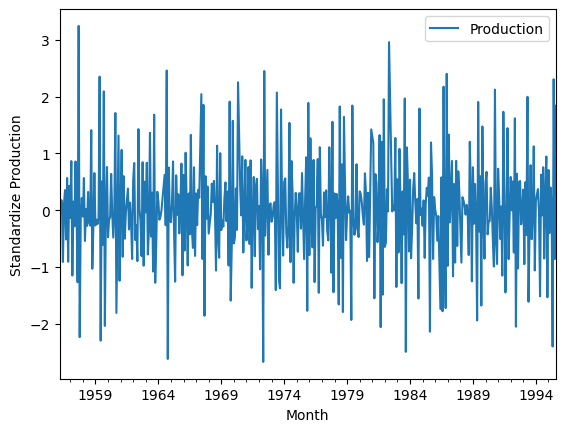

In [34]:
# Display graph without outliers / anomalies
df_beer.plot()
plt.ylabel('Standardize Production')
plt.show()

That's it! 
You are almost ready to go! 
You could potentially smooth the data, but that's what we'll cover in the next article.

------

#### [💊Machine Learning Pills💊](https://mlpills.dev/)

**Follow me on Twitter**: [@daansan_ml](https://twitter.com/daansan_ml)

### **David Andrés** 🤖📈🐍 